## Importing and prepping data

In [1]:
import pandas as pd

import diff_classifier.aws as aws
import diff_classifier.pca as pca

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

In [2]:
features = []
#featofvar = 'Type and Serum'

remote_folder = '09_19_19_size_dependent_study_2' #Folder in AWS S3 containing files to be analyzed
bucket = 'mckenna.data'
vids = 5
types = ['40', '100']
slices = [1, 2, 3, 4]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            try:
                filename = 'features_40red_100YG_{}_w{}_v{}.csv'.format(typ, slic, num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1")
                
                for extra in extras:
                    fstats[extra] = fstats.index
                fstats = fstats.drop(extras, axis=1)
                
                print('{} size: {}'.format(filename, fstats.shape))
                if '40' in typ:
                    fstats['Size'] = pd.Series(fstats.shape[0]*['40'], index=fstats.index)
                else:
                    fstats['Size'] = pd.Series(fstats.shape[0]*['200'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                fstats['Well Number'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))

features_40red_100YG_40_w1_v1.csv
features_40red_100YG_40_w1_v1.csv size: (10536, 67)
features_40red_100YG_40_w1_v2.csv
features_40red_100YG_40_w1_v2.csv size: (9760, 67)
features_40red_100YG_40_w1_v3.csv
features_40red_100YG_40_w1_v3.csv size: (9561, 67)
features_40red_100YG_40_w1_v4.csv
features_40red_100YG_40_w1_v4.csv size: (9761, 67)
features_40red_100YG_40_w1_v5.csv
features_40red_100YG_40_w1_v5.csv size: (10883, 67)
features_40red_100YG_40_w2_v1.csv
features_40red_100YG_40_w2_v1.csv size: (37285, 67)
features_40red_100YG_40_w2_v2.csv
features_40red_100YG_40_w2_v2.csv size: (4271, 67)
features_40red_100YG_40_w2_v3.csv
features_40red_100YG_40_w2_v3.csv size: (43951, 67)
features_40red_100YG_40_w2_v4.csv
features_40red_100YG_40_w2_v4.csv size: (35343, 67)
features_40red_100YG_40_w2_v5.csv
features_40red_100YG_40_w2_v5.csv size: (36160, 67)
features_40red_100YG_40_w3_v1.csv
features_40red_100YG_40_w3_v1.csv size: (675, 67)
features_40red_100YG_40_w3_v2.csv
features_40red_100YG_40_w3

In [24]:
nonnum = ['Size', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index']
nonnum = ['Size', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index', 'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis',
          'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2', 'Std asymmetry2', 'Mean asymmetry3',
          'Std asymmetry3', 'Mean AR', 'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness', 'Std boundedness',
          'Mean fractal_dim', 'Std fractal_dim', 'Mean trappedness', 'Std trappedness', 'Mean efficiency', 'Std efficiency',
          'Mean straightness', 'Std straightness', 'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
          'Mean Deff1', 'Std Deff1', 'Mean Deff2', 'Std Deff2']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [25]:
ncomp = 6
pcadataset = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.37194987907342053
1 component: 0.5030333060615991
2 component: 0.6194737385772983
3 component: 0.724163684317567
4 component: 0.7833090712489161
5 component: 0.8337879153227707


In [26]:
pcadataset.prcomps

,0,1,2,3,4,5
0,asymmetry3,MSD_ratio,frames,Deff1,Deff2,kurtosis
1,asymmetry2,alpha,trappedness,D_fit,kurtosis,MSD_ratio
2,fractal_dim,asymmetry2,boundedness,kurtosis,Deff1,Deff2
3,asymmetry1,asymmetry1,straightness,alpha,D_fit,D_fit
4,elongation,asymmetry3,D_fit,fractal_dim,frames,Deff1


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [27]:
pca_train = pcadataset

In [28]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

In [11]:
kmostat = pca.kmo(pca_train.scaled)

0.874543500652


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [15]:
pca_train.final['Size']

0          40
1          40
2          40
3          40
4          40
5          40
6          40
7          40
8          40
9          40
10         40
11         40
12         40
13         40
14         40
15         40
16         40
17         40
18         40
19         40
20         40
21         40
22         40
23         40
24         40
25         40
26         40
27         40
28         40
29         40
         ... 
249779    200
249780    200
249781    200
249782    200
249783    200
249784    200
249785    200
249786    200
249787    200
249788    200
249789    200
249790    200
249791    200
249792    200
249793    200
249794    200
249795    200
249796    200
249797    200
249798    200
249799    200
249800    200
249801    200
249802    200
249803    200
249804    200
249805    200
249806    200
249807    200
249808    200
Name: Size, Length: 249809, dtype: object

In [29]:
import numpy as np
featofvar = 'Size'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='40'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='200'].values[:, -ncomp:], axis=0)

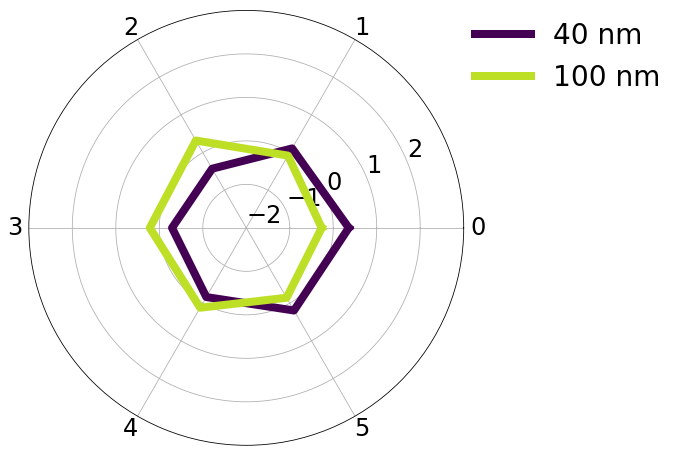

In [32]:
labels2 = ['40 nm', '100 nm']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-2, 2, 5), dpi=1200, labelsize=24,
             filename='pics/size_mixed_40red_100YG_pcaavg_small.png')

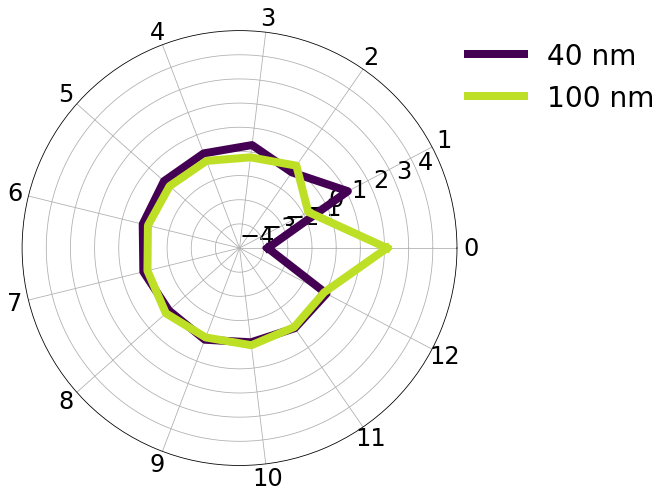

In [17]:
labels2 = ['40 nm', '100 nm']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-4, 4, 9), dpi=1200, labelsize=24,
             filename='pics/size_mixed_40red_100YG_pcaavg.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 2)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

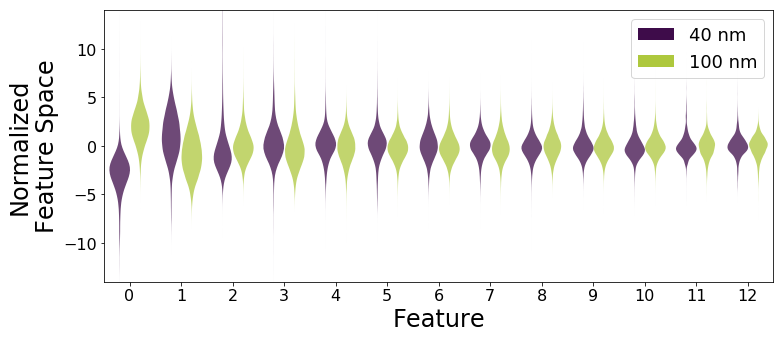

In [19]:
labels3 = ['40 nm', '100 nm']
labels = ['40', '200']
feats = feature_violin(pcadataset.final, label='Size', lvals=labels, labels=labels3, fsubset=ncomp, yrange=[-14, 14],
                       legendfontsize=18, labelsize=24, fname='./pics/size_mixed_40red_100YG_pcadist.png')

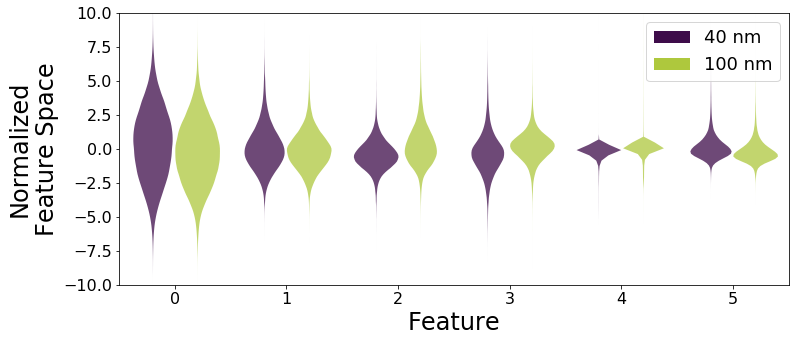

In [33]:
labels3 = ['40 nm', '100 nm']
labels = ['40', '200']
feats = feature_violin(pcadataset.final, label='Size', lvals=labels, labels=labels3, fsubset=ncomp, yrange=[-10, 10],
                       legendfontsize=18, labelsize=24, fname='./pics/size_mixed_40red_100YG_pcadist_small.png')

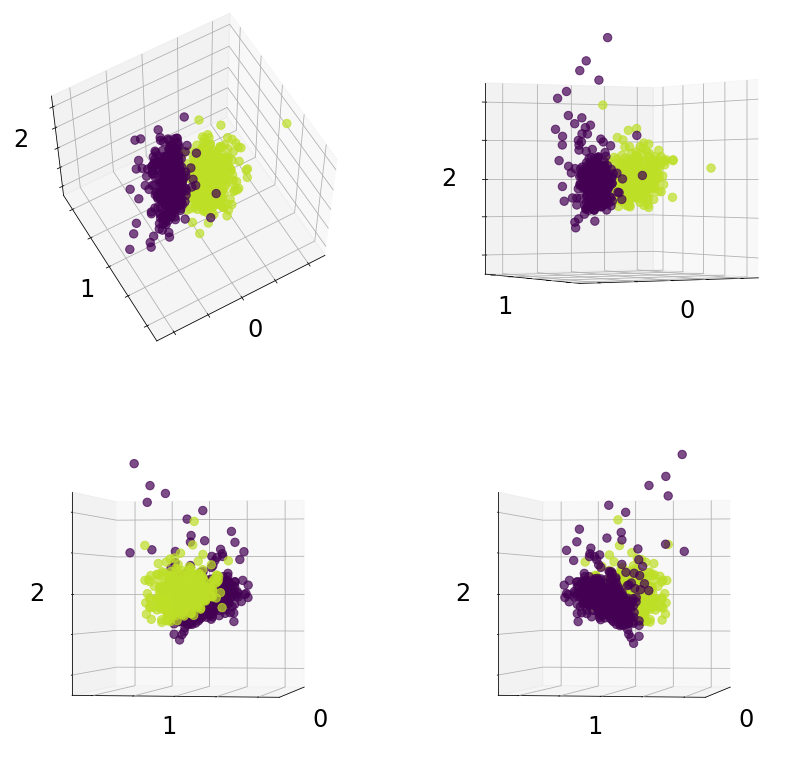

In [23]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/size_mixed_40red_100YG_3feats.png')

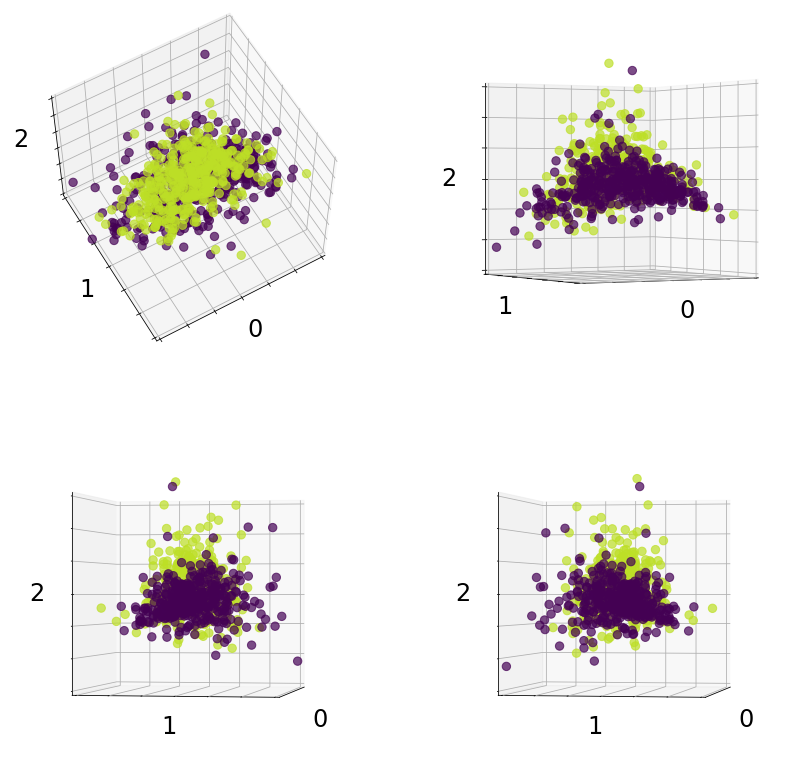

In [34]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=labels, randcount=400, ylim=[-6, 6],
                              xlim=[-6, 6], zlim=[-6, 6], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/size_mixed_40red_100YG_3feats_small.png')

## Neural Network

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [22]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.03346458
Validation score: 0.995637
Iteration 2, loss = 0.01853656
Validation score: 0.996437
Iteration 3, loss = 0.01509003
Validation score: 0.996838
Iteration 4, loss = 0.01288872
Validation score: 0.997398
Iteration 5, loss = 0.01140018
Validation score: 0.997638
Iteration 6, loss = 0.01017037
Validation score: 0.997718
Iteration 7, loss = 0.00925505
Validation score: 0.998119
Iteration 8, loss = 0.00846670
Validation score: 0.998239
Iteration 9, loss = 0.00778093
Validation score: 0.998399
Iteration 10, loss = 0.00724739
Validation score: 0.998719
Iteration 11, loss = 0.00676816
Validation score: 0.998879
Iteration 12, loss = 0.00638115
Validation score: 0.998799
Iteration 13, loss = 0.00600037
Validation score: 0.998799
Iteration 14, loss = 0.00570666
Validation score: 0.999039
Iteration 15, loss = 0.00535157
Validation score: 0.999239
Iteration 16, loss = 0.00514319
Validation score: 0.999119
Iteration 17, loss = 0.00488709
Validation score: 0.999360
Iterat

In [35]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.55605796
Validation score: 0.708619
Iteration 2, loss = 0.54910377
Validation score: 0.712822
Iteration 3, loss = 0.54729854
Validation score: 0.712702
Iteration 4, loss = 0.54639091
Validation score: 0.711901
Iteration 5, loss = 0.54569027
Validation score: 0.715023
Iteration 6, loss = 0.54520355
Validation score: 0.713382
Iteration 7, loss = 0.54478724
Validation score: 0.714863
Iteration 8, loss = 0.54428906
Validation score: 0.714263
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 9, loss = 0.54221256
Validation score: 0.716465
Iteration 10, loss = 0.54200798
Validation score: 0.716344
Iteration 11, loss = 0.54182864
Validation score: 0.716384
Iteration 12, loss = 0.54175405
Validation score: 0.716344
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.54123445
Validation score: 0.716705
Iterat

In [36]:
X_train = pca_train.final
X_test = pca_test.final

In [37]:
X_train['LogDeff1'] = np.log(X_train['Deff1']).replace([np.inf, -np.inf], np.nan)
X_test['LogDeff1'] = np.log(X_test['Deff1']).replace([np.inf, -np.inf], np.nan)

In [40]:
kb = 1.381*10**-23
T = 310
nu = 0.000797
sizes = ['40', '200']
sizesbins = np.array([70])
lambd = 1.33

logDeff = np.log(10**9*10**12*kb*T/(lambd**2*sizesbins*3*np.pi*nu))
print(logDeff)

[ 1.52667056]


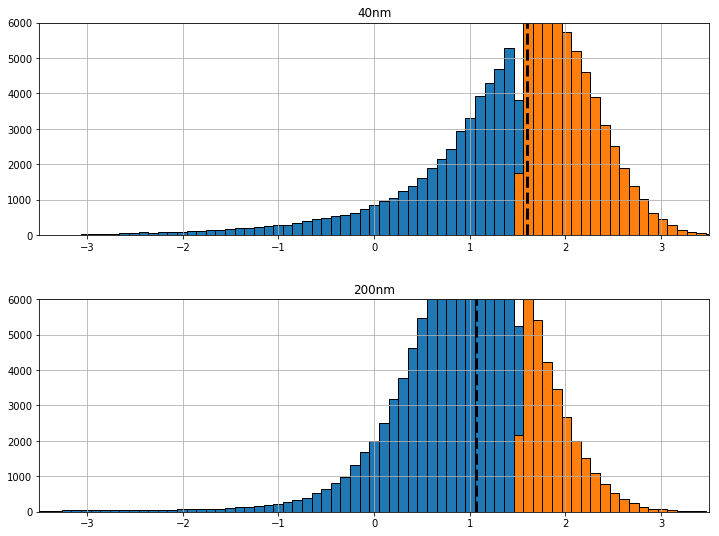

In [42]:
Dbins = [-10, 1.527, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(2):
        X_train[(X_train['Size']==sizes[counter]) & (Dbins[i] < X_train['LogDeff1']) & (X_train['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-3.5, 3.5])
        ax.set_ylim([0, 6000])
    ax.axvline(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [43]:
y_pred2 = list(pd.cut(X_train.LogDeff1.values, bins=[-10, 1.527, 1000], labels=['40', '200']).astype(str))
y_true2 = X_train['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.3516    0.2173    0.2686    143327
         40     0.3042    0.4606    0.3664    106482
        nan     0.0000    0.0000    0.0000         0

avg / total     0.3314    0.3210    0.3103    249809



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [44]:
y_pred2 = list(pd.cut(X_test.LogDeff1.values, bins=[-10, 1.527, 1000], labels=['40', '200']).astype(str))
y_true2 = X_test['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.3521    0.2187    0.2698    142895
         40     0.3132    0.4695    0.3757    108446
        nan     0.0000    0.0000    0.0000         0

avg / total     0.3353    0.3269    0.3155    251341



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


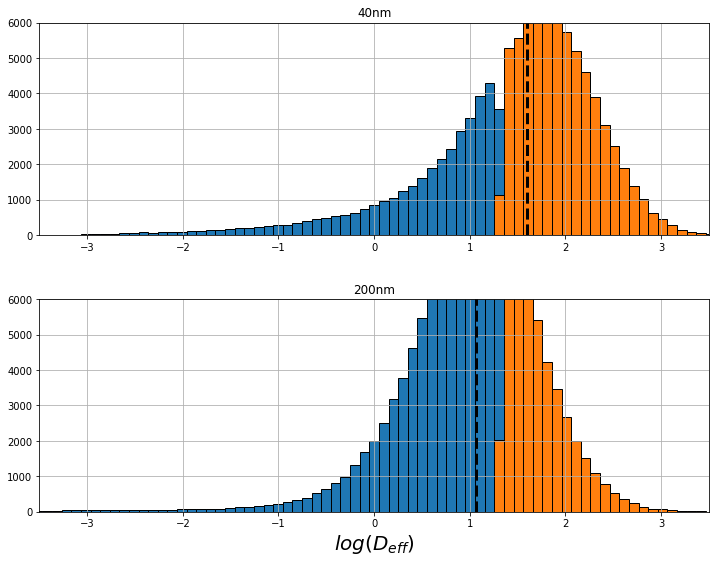

In [47]:
Dbins = [-10, 1.333, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(2):
        X_train[(X_train['Size']==sizes[counter]) & (Dbins[i] < X_train['LogDeff1']) & (X_train['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-3.5, 3.5])
        ax.set_ylim([0, 6000])
    ax.axvline(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 1:
        ax.set_xlabel(r'$log(D_{eff})$', size=20)
    counter = counter + 1

In [45]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[ 1.33259771]


In [52]:
y_pred2 = list(pd.cut(X_train.LogDeff1.values, bins=[-10, 0.7582, 1000], labels=['200', '40']).astype(str))
y_true2 = X_train['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.7074    0.3112    0.4323    143327
         40     0.4714    0.8266    0.6004    106482
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6068    0.5309    0.5039    249809



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [53]:
y_pred2 = list(pd.cut(X_test.LogDeff1.values, bins=[-10, 0.7582, 1000], labels=['200', '40']).astype(str))
y_true2 = X_test['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.6935    0.3114    0.4298    142895
         40     0.4743    0.8185    0.6006    108446
        nan     0.0000    0.0000    0.0000         0

avg / total     0.5989    0.5302    0.5035    251341



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [51]:
pd.cut(X_train.LogDeff1.values, bins=[-10, 0.7582, 1000], labels=['40', '200'])

[200, 40, 200, 200, 200, ..., 200, 200, 40, 200, 200]
Length: 249809
Categories (2, object): [40 < 200]

In [55]:
size_100 = pca_train.final[pca_train.final['Size'] == '200'].shape[0]
#size_tbd = int(size_100+500*np.random.random(1)[0])

In [61]:
size_40 = pca_train.final[pca_train.final['Size'] == '40'].shape[0]
size_tbd = int(size_40+500*np.random.random(1)[0])

In [69]:
pca_train.final = pca_train.final.drop(labels='LogDeff1', axis=1)
pca_test.final = pca_test.final.drop(labels='LogDeff1', axis=1)

In [81]:
size_40 = pca_train.final[pca_train.final['Size'] == '40'].shape[0]
size_tbd = int(size_40+500*np.random.random(1)[0])
pca_train1 = pd.concat([pca_train.final[pca_train.final['Size'] == '200'].sample(n=size_tbd), pca_train.final[pca_train.final['Size'] == '40']], axis=0, ignore_index=True)

size_40 = pca_test.final[pca_test.final['Size'] == '40'].shape[0]
size_tbd = int(size_40+500*np.random.random(1)[0])
pca_test1 = pd.concat([pca_test.final[pca_test.final['Size'] == '200'].sample(n=size_tbd), pca_test.final[pca_test.final['Size'] == '40']], axis=0, ignore_index=True)

In [82]:
X_train = pca_train1.values[:, -ncomp:]
X_test = pca_test1.values[:, -ncomp:]
y_train = pca_train1[featofvar].values
y_test = pca_test1[featofvar].values

In [83]:
for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.56347361
Validation score: 0.706705
Iteration 2, loss = 0.55600289
Validation score: 0.708394
Iteration 3, loss = 0.55406569
Validation score: 0.706893
Iteration 4, loss = 0.55314084
Validation score: 0.709379
Iteration 5, loss = 0.55236734
Validation score: 0.711256
Iteration 6, loss = 0.55181049
Validation score: 0.708722
Iteration 7, loss = 0.55141610
Validation score: 0.709895
Iteration 8, loss = 0.55090281
Validation score: 0.709285
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 9, loss = 0.54885893
Validation score: 0.710787
Iteration 10, loss = 0.54855282
Validation score: 0.710318
Iteration 11, loss = 0.54846425
Validation score: 0.711960
Iteration 12, loss = 0.54838095
Validation score: 0.709098
Iteration 13, loss = 0.54821915
Validation score: 0.710881
Iteration 14, loss = 0.54816833
Validation score: 0.711960
Validation score did not improve more than tol=0.000010 for two c

In [84]:
X_train = pca_train1
X_test = pca_test1
y_train = pca_train1[featofvar].values
y_test = pca_test1[featofvar].values

In [85]:
X_train['LogDeff1'] = np.log(X_train['Deff1']).replace([np.inf, -np.inf], np.nan)
X_test['LogDeff1'] = np.log(X_test['Deff1']).replace([np.inf, -np.inf], np.nan)

In [86]:
kb = 1.381*10**-23
T = 310
nu = 0.000797
sizes = ['40', '200']
sizesbins = np.array([70])
lambd = 1.33

logDeff = np.log(10**9*10**12*kb*T/(lambd**2*sizesbins*3*np.pi*nu))
print(logDeff)

[ 1.52667056]


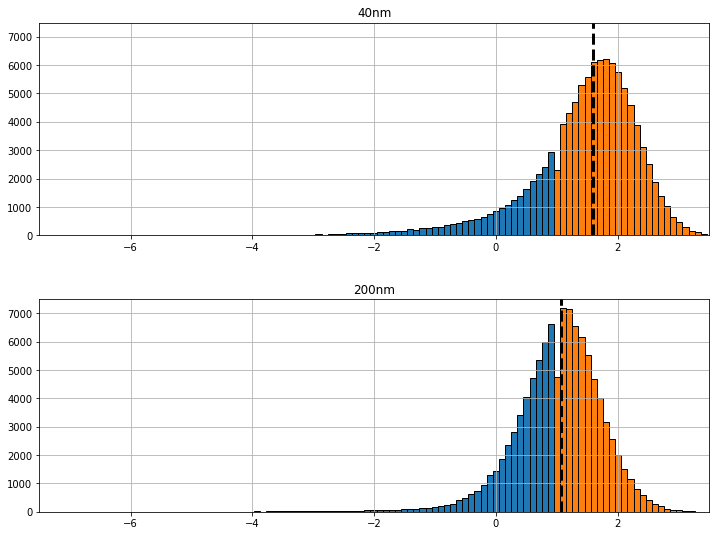

In [88]:
Dbins = [-10, 0.9877, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(2):
        X_train[(X_train['Size']==sizes[counter]) & (Dbins[i] < X_train['LogDeff1']) & (X_train['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 7500])
    ax.axvline(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [89]:
y_pred2 = list(pd.cut(X_train.LogDeff1.values, bins=[-10, 1.527, 1000], labels=['200', '40']).astype(str))
y_true2 = X_train['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.6298    0.7823    0.6978    106645
         40     0.7121    0.5393    0.6138    106482
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6709    0.6609    0.6558    213127



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [91]:
y_pred2 = list(pd.cut(X_test.LogDeff1.values, bins=[-10, 1.527, 1000], labels=['200', '40']).astype(str))
y_true2 = X_test['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.6245    0.7800    0.6937    108571
         40     0.7066    0.5304    0.6060    108446
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6656    0.6553    0.6499    217017



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [92]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[ 1.3333058]


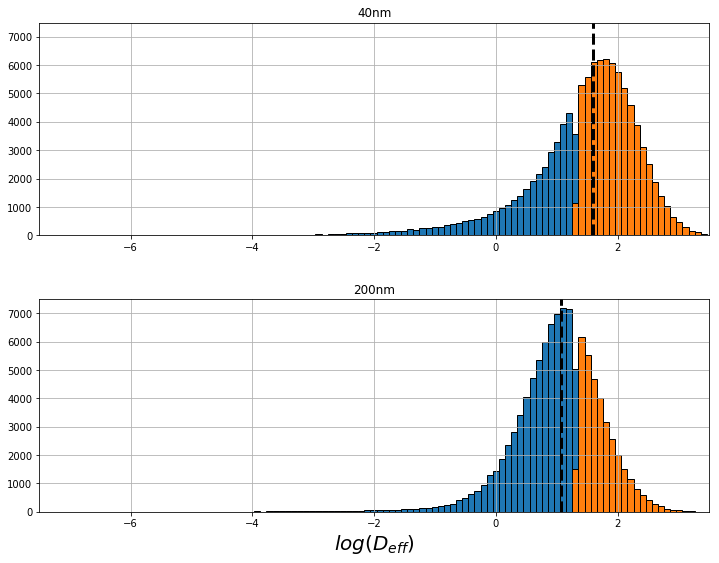

In [93]:
Dbins = [-10, 1.333, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(2):
        X_train[(X_train['Size']==sizes[counter]) & (Dbins[i] < X_train['LogDeff1']) & (X_train['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 7500])
    ax.axvline(X_train[X_train['Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 1:
        ax.set_xlabel(r'$log(D_{eff})$', size=20)
    counter = counter + 1

In [94]:
y_pred2 = list(pd.cut(X_train.LogDeff1.values, bins=[-10, 1.333, 1000], labels=['200', '40']).astype(str))
y_true2 = X_train['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.6493    0.6736    0.6612    106645
         40     0.6604    0.6355    0.6477    106482
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6548    0.6546    0.6545    213127



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [96]:
y_pred2 = list(pd.cut(X_test.LogDeff1.values, bins=[-10, 1.333, 1000], labels=['200', '40']).astype(str))
y_true2 = X_test['Size'].values

print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        200     0.6418    0.6690    0.6551    108571
         40     0.6539    0.6261    0.6397    108446
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6478    0.6475    0.6474    217017



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
